<a href="https://colab.research.google.com/github/heehminh/SkinHelper-CNN/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available.")
    device = torch.device("cuda")
    print("Using CUDA device:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")


CUDA is available.
Using CUDA device: Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import Libraries

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

# 2. Import Data

In [4]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/archive/hmnist_28_28_RGB.csv')

In [5]:
y = data['label']
x = data.drop(columns = ['label'])

In [6]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [7]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


# 3. Exploratory Data Analysis (EDA)

In [8]:
tabular_data = pd.read_csv('/content/drive/MyDrive/archive/HAM10000_metadata.csv')
tabular_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [10]:
classes = {
    4: ('nv', ' melanocytic nevi'),
    6: ('mel', 'melanoma'),
    2 :('bkl', 'benign keratosis-like lesions'),
    1:('bcc' , ' basal cell carcinoma'),
    5: ('vasc', ' pyogenic granulomas and hemorrhage'),
    0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
    3: ('df', 'dermatofibroma')
}

Text(0.5, 1.0, 'Frequency Distribution of Classes')

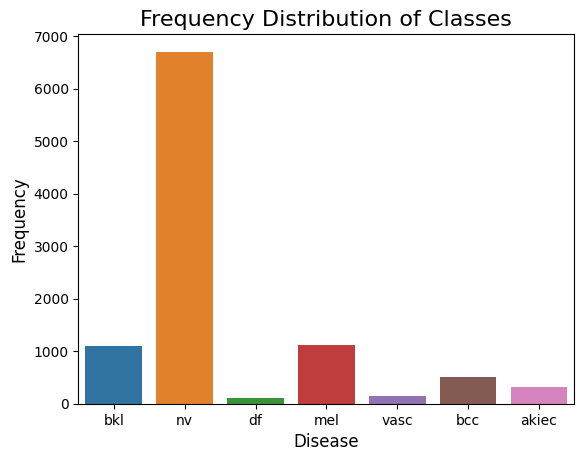

In [11]:
"""Frequency Distribution of Classes"""

sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

# 4. Oversampling

In [12]:
t = np.zeros([46935, 32, 32, 3],dtype=np.float32)
print(t.shape)

(46935, 32, 32, 3)


In [13]:
import scipy.ndimage

In [ ]:
for i in range(46935):
    t[i] = scipy.ndimage.zoom(x[i],32/28)

In [ ]:
x = np.array(t).reshape(-1,32,32,3)
print('Shape of X :',x.shape)

In [ ]:
"""Standardization and Splitting Data"""

x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

# 5. Model Training

In [ ]:
vgg=tf.keras.applications.VGG16(input_shape=(32,32,3),weights='imagenet', include_top=False)
for i in vgg.layers:
    i.trainable = False

In [20]:
model = tf.keras.models.Sequential([
    vgg,
    # tf.keras.layers.Conv2D(128, (3, 3), padding="same"),
    # tf.keras.layers.Activation("relu"),
    # tf.keras.layers.Conv2D(64, (3, 3), padding="same"),
    # tf.keras.layers.Activation("relu"),
    # tf.keras.layers.Conv2D(32, (3, 3), padding="same"),
    # tf.keras.layers.Activation("relu"),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation = 'softmax')
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 14718279 (56.15 MB)
Trainable params: 3591 (14.03 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
None


In [ ]:
# model = Sequential()
# model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
# model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2)))
# model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
# model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(7, activation='softmax'))
# model.summary()

In [21]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_acc',
    mode='max',
    verbose=1
)

In [22]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 100,
                    callbacks=[callback])

Epoch 1/100
235/235 [==============================] - ETA: 0s - loss: 1.4334 - accuracy: 0.4716
Epoch 1: saving model to best_model.h5
235/235 [==============================] - 19s 29ms/step - loss: 1.4334 - accuracy: 0.4716 - val_loss: 1.2018 - val_accuracy: 0.5590
Epoch 2/100
  1/235 [..............................] - ETA: 4s - loss: 1.1574 - accuracy: 0.5781

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


235/235 [==============================] - ETA: 0s - loss: 1.1238 - accuracy: 0.5932
Epoch 2: saving model to best_model.h5
235/235 [==============================] - 6s 26ms/step - loss: 1.1238 - accuracy: 0.5932 - val_loss: 1.0686 - val_accuracy: 0.6109
Epoch 3/100
235/235 [==============================] - ETA: 0s - loss: 1.0259 - accuracy: 0.6269
Epoch 3: saving model to best_model.h5
235/235 [==============================] - 6s 25ms/step - loss: 1.0259 - accuracy: 0.6269 - val_loss: 0.9965 - val_accuracy: 0.6308
Epoch 4/100
234/235 [============================>.] - ETA: 0s - loss: 0.9645 - accuracy: 0.6492
Epoch 4: saving model to best_model.h5
235/235 [==============================] - 6s 26ms/step - loss: 0.9650 - accuracy: 0.6490 - val_loss: 0.9504 - val_accuracy: 0.6550
Epoch 5/100
234/235 [============================>.] - ETA: 0s - loss: 0.9234 - accuracy: 0.6639
Epoch 5: saving model to best_model.h5
235/235 [==============================] - 6s 25ms/step - loss: 0.9232 -

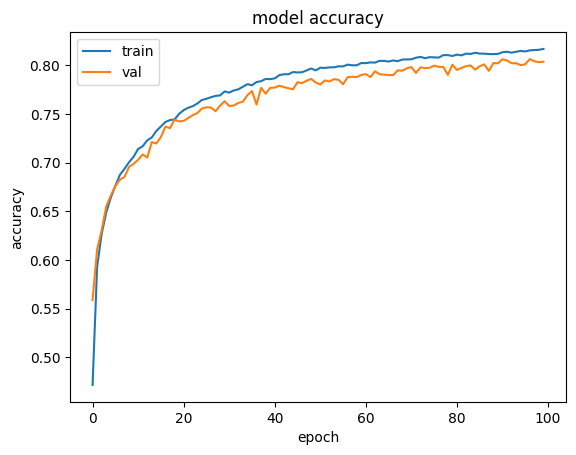

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

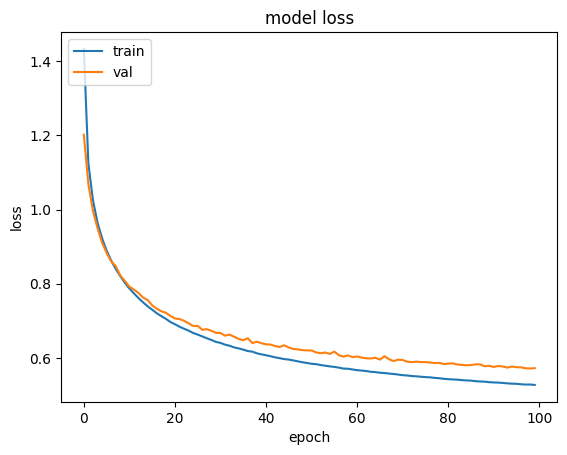

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
model.load_weights('best_model.h5')

# 6. Model Testing

In [26]:
loss, acc = model.evaluate(X_train, Y_train, verbose=2)

1174/1174 - 10s - loss: 0.5329 - accuracy: 0.8150 - 10s/epoch - 8ms/step


In [27]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

294/294 - 3s - loss: 0.5849 - accuracy: 0.7954 - 3s/epoch - 9ms/step


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

In [29]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)

confusion_matrix = metrics.confusion_matrix(y_true=Y_test, y_pred=y_pred_labels)

294/294 [==============================] - 3s 8ms/step


In [30]:
class_labels = ['akiec','bcc','bkl','df','nv','vasc','mel']
report = sklearn.metrics.classification_report(Y_test, y_pred_labels, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.77      0.86      0.81      1359
         bcc       0.80      0.76      0.78      1318
         bkl       0.62      0.61      0.62      1262
          df       0.92      0.99      0.95      1351
          nv       0.80      0.68      0.74      1374
        vasc       0.98      1.00      0.99      1358
         mel       0.66      0.65      0.65      1365

    accuracy                           0.80      9387
   macro avg       0.79      0.79      0.79      9387
weighted avg       0.79      0.80      0.79      9387



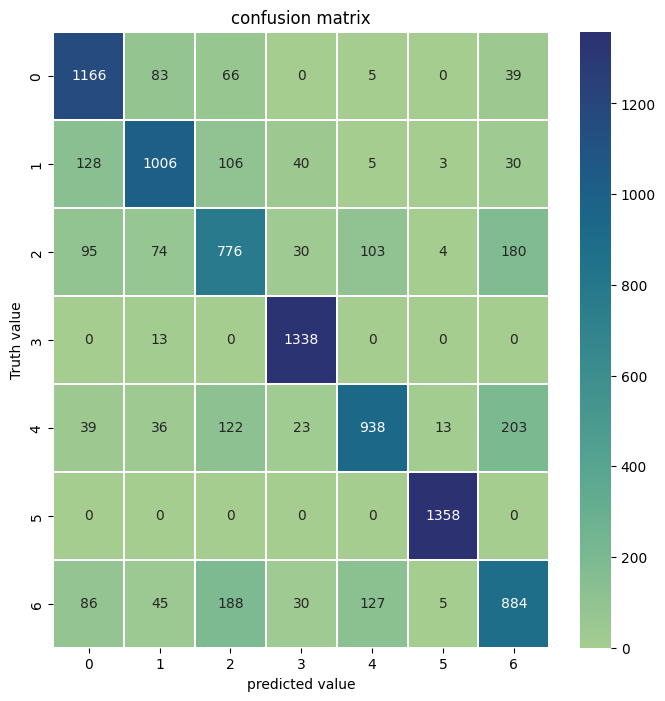

[[1166   83   66    0    5    0   39]
 [ 128 1006  106   40    5    3   30]
 [  95   74  776   30  103    4  180]
 [   0   13    0 1338    0    0    0]
 [  39   36  122   23  938   13  203]
 [   0    0    0    0    0 1358    0]
 [  86   45  188   30  127    5  884]]


In [31]:
cm = sklearn.metrics.confusion_matrix(Y_test, y_pred_labels)
plt.figure(figsize=(8,8))
sns.heatmap(cm, fmt='.0f', cmap="crest", annot=True, linewidths=0.2 )
plt.title('confusion matrix')
plt.xlabel('predicted value')
plt.ylabel('Truth value')
plt.show()
print(sklearn.metrics.confusion_matrix(Y_test, y_pred_labels))

# 7. Prediction

In [34]:
classes = {
    4: ('nv', ' melanocytic nevi'),
    6: ('mel', 'melanoma'),
    2 :('bkl', 'benign keratosis-like lesions'),
    1:('bcc' , ' basal cell carcinoma'),
    5: ('vasc', ' pyogenic granulomas and hemorrhage'),
    0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
    3: ('df', 'dermatofibroma')
}

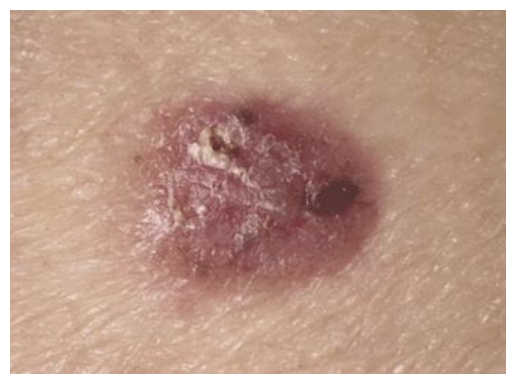

1/1 [==============================] - 0s 286ms/step
Model Prediction: [[0. 0. 0. 0. 0. 1. 0.]]
Top-1 Prediction:
Class: vasc, Description:  pyogenic granulomas and hemorrhage, Probability: 1.0000


In [40]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# 모델 로드
model_path = '/content/drive/MyDrive/skin-helper-cnn/best_model.h5'
model = load_model(model_path)

# 이미지 로드
image_path = '/content/drive/MyDrive/skin-helper-cnn/test3-basal.png'
image = cv2.imread(image_path)
image = cv2.resize(image, (32, 32))  # 모델에 맞는 크기로 조정
image = np.expand_dims(image, axis=0)  # 배치 차원 추가

# 이미지 출력
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# 모델 예측 (각 class의 확률)
prediction = model.predict(image)

# 예측 결과 출력
print("Model Prediction:", prediction)

# Top-1 예측
top1_class = np.argmax(prediction)
top1_label, top1_description = classes[top1_class]
top1_prob = prediction[0, top1_class]

# 출력
print("Top-1 Prediction:")
print(f"Class: {top1_label}, Description: {top1_description}, Probability: {top1_prob:.4f}")


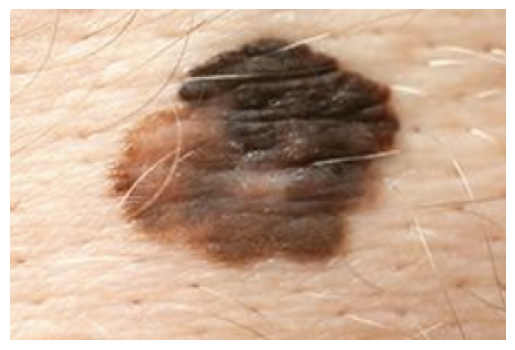

1/1 [==============================] - 1s 1s/step
Model Prediction: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.0766937e-24
  0.0000000e+00 1.0000000e+00]]
Top-1 Prediction:
Class: mel, Description: melanoma, Probability: 1.0000


In [41]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# 모델 로드
model_path = '/content/drive/MyDrive/skin-helper-cnn/best_model.h5'
model = load_model(model_path)

# 이미지 로드
image_path = '/content/drive/MyDrive/skin-helper-cnn/test4-mel.png'
image = cv2.imread(image_path)
image = cv2.resize(image, (32, 32))  # 모델에 맞는 크기로 조정
image = np.expand_dims(image, axis=0)  # 배치 차원 추가

# 이미지 출력
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# 모델 예측 (각 class의 확률)
prediction = model.predict(image)

# 예측 결과 출력
print("Model Prediction:", prediction)

# Top-1 예측
top1_class = np.argmax(prediction)
top1_label, top1_description = classes[top1_class]
top1_prob = prediction[0, top1_class]

# 출력
print("Top-1 Prediction:")
print(f"Class: {top1_label}, Description: {top1_description}, Probability: {top1_prob:.4f}")
